In [1]:
import covasim as cv
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns

cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

Covasim 3.1.1 (2021-12-06) — © 2021 by IDM


In [2]:
contact_dir = '/mnt/d/books/iitm/agentBased/codes/tn_contact_matrix/output/contact_matrix'
home_path = join(contact_dir, 'home_contact.csv')
school_path = join(contact_dir, 'school_contact.csv')
work_path = join(contact_dir, 'work_contact.csv')
community_path = join(contact_dir, 'community_contact.csv')

In [3]:
fb_dir = '/mnt/d/books/iitm/agentBased/codes/covasim/models/data/'
tile_path = join(fb_dir, 'tn_quadkey.csv')
density_path = join(fb_dir, 'pop_density.csv')
mobility_path = '/mnt/d/books/iitm/agentBased/data/fb/mobility/'

In [4]:
case_datafile = '/mnt/d/books/iitm/agentBased/data/tn/incovid19/covasim/state_datafile.csv'

In [5]:
start_day, end_day = '2020-06-01', '2020-06-30'

In [6]:
df = pd.read_csv(case_datafile, delimiter=',')
df = df[(df['date']>=start_day) & (df['date']<=end_day)]

refactor_file = '/mnt/d/books/iitm/agentBased/data/tn/incovid19/covasim/tmp_datafile.csv'
df.to_csv(refactor_file, sep=',', index=False, header=True)
df.head(n=5)

,date,new_tests,new_diagnoses,new_recoveries,new_deaths
86,2020-06-01,11377,1162,413,11
87,2020-06-02,11094,1091,536,13
88,2020-06-03,14101,1286,610,8
89,2020-06-04,16447,1384,585,15
90,2020-06-05,15692,1438,861,12


In [7]:
asymptotic_rate = 0.3
pop_infected = (22333 - 12757) * (1 + asymptotic_rate)

In [8]:
age_based_infection = [0.045455, 0.009091, 0.014773, 0.00000, 0.051136, 0.022727, 0.068182, 0.102273, 0.211364, 0.029924, 0.120833, 0.117424, 0.04697, 0.063636, 0.000000, 0.096212]
tile_infection = [0.        , 0.00430416, 0.00215208, 0.04925873, 0.00023912,
       0.00454328, 0.03778097, 0.02223816, 0.00621712, 0.15845688,
       0.01721664, 0.17663   , 0.14506616, 0.01602104, 0.0215208 ,
       0.0143472 , 0.04710665, 0.00701419, 0.04949785, 0.05499761,
       0.02662203, 0.01960784, 0.01259366, 0.00557947, 0.01769488,
       0.0263032 , 0.00557947, 0.00765184, 0.02941176, 0.0143472 ,
       0.        ]

In [9]:
len(tile_infection)

31

In [10]:
pars = dict(
    start_day = start_day,
    end_day = end_day,

    pop_type = 'matrix', # Use a more realistic population model
    location = 'India-TamilNadu', # Use population characteristics for Tamil-Nadu

    pop_size = 1_000_000,
    pop_scale = 7,
    rescale = True,
    pop_infected = pop_infected,

    home_matrix=home_path,
    school_matrix = school_path,
    work_matrix = work_path,
    community_matrix = community_path,

    tiles = tile_path,
    pop_density = density_path,
    mobility = mobility_path,

    use_waning = True,
    dynam_layer={'c': True},

    init_infection={'tiles':tile_infection, 'ages':age_based_infection},
    
    beta=0.030216941498219296,
    rel_death_prob=2.6190536217375318,

    rand_seed=2
)

In [26]:
# Compare matrix model

pars['pop_type'] = 'matrix'
sim = cv.Sim(pars, datafile=refactor_file, interventions=cv.test_num(daily_tests='data'))
sim.run()

Sim(<no label>; 2020-06-01 to 2020-06-30; pop: 100000 matrix; epi: 18874⚙, 56☠)

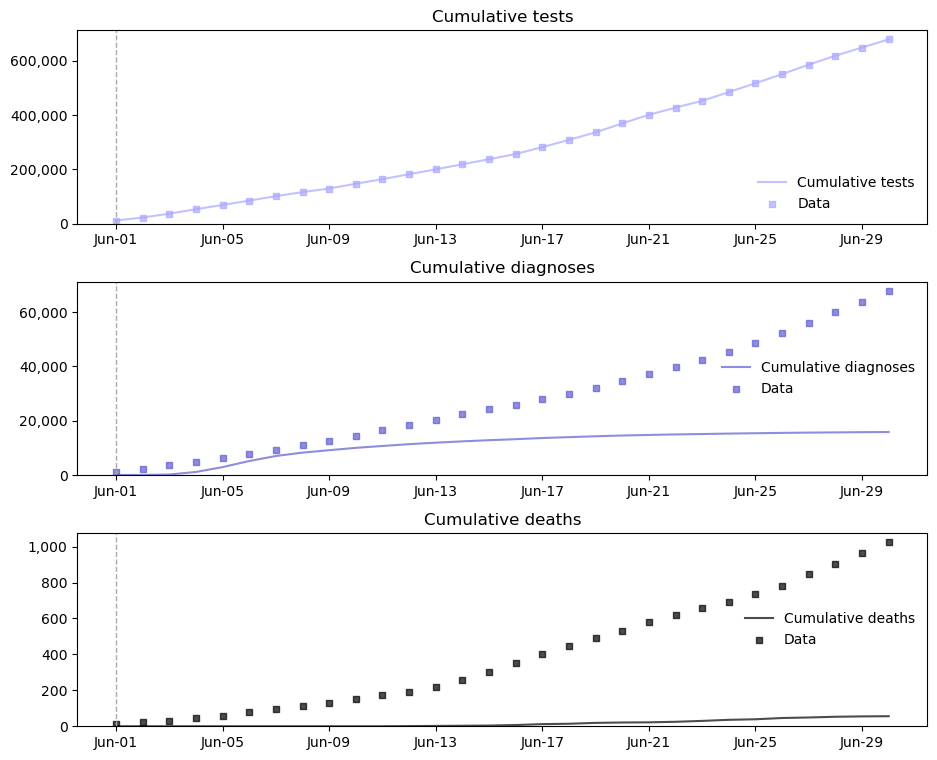

In [27]:
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

In [ ]:
date_v = sim.datevec.tolist()

In [ ]:
sim.result_keys()

In [11]:
!pip install optuna

In [ ]:
import sciris as sc

pars['beta'] = 0.015
pars['rel_death_prob'] = 1.0

sim = cv.Sim(pars=pars, datafile=refactor_file, interventions=cv.test_num(daily_tests='data'))

calib_pars = dict(
    beta           = [pars['beta'], 0.005, 0.20],
    rel_death_prob = [pars['rel_death_prob'], 0.5, 3.0],
)

fit_agrs = dict(
    weights = {'new_diagnoses': 0.25, 'new_recoveries': 0.25 , 'new_deaths': 0.5},
    keys = ['new_diagnoses', 'new_recoveries', 'new_deaths'],
    normalize=False,
    use_squared=True,
    as_scalar='mean'
)

n_trials = 5
n_workers = 4
calib = sim.calibrate(calib_pars=calib_pars, n_trials=n_trials, n_workers=n_workers)

In [14]:
calib.summarize()

Calibration for 20 total trials completed in 2909.1 s.

Initial parameter values:
#0. beta:           0.015
#1. rel_death_prob: 1.0

Best parameter values:
#0. beta:           0.030216941498219296
#1. rel_death_prob: 2.6190536217375318

Mismatch before calibration: 149.31
Mismatch after calibration:  127.285
Percent improvement:         14.8%


(149.3098254203051, 127.28469612575024)

In [ ]:
# # Custom objective running using scipy

# import scipy

# def objective(x, n_runs=10):
#     print(f'Running sim for beta={x[0]}, rel_death_prob={x[1]}')
#     pars = dict(
#         start_day = start_day,
#         end_day = end_day,

#         pop_type = 'matrix', # Use a more realistic population model
#         location = 'India-TamilNadu', # Use population characteristics for Tamil-Nadu

#         pop_size = 700_000,
#         pop_scale = 10,
#         rescale = True,
#         pop_infected = pop_infected,

#         home_matrix=home_path,
#         school_matrix = school_path,
#         work_matrix = work_path,
#         community_matrix = community_path,

#         tiles = tile_path,
#         pop_density = density_path,
#         mobility = mobility_path,

#         use_waning = True,
#         dynam_layer={'c': True},

#         init_infection={'tiles':tile_infection, 'ages':age_based_infection},

#         beta           = x[0],
#         rel_death_prob = x[1],
#         verbose        = 0,
#     )
#     sim = cv.Sim(pars=pars, datafile=refactor_file, interventions=cv.test_num(daily_tests='data'))
#     msim = cv.MultiSim(sim)
#     msim.run(n_runs=n_runs)
#     mismatches = []
#     for sim in msim.sims:
#         fit = sim.compute_fit()
#         mismatches.append(fit.mismatch)
#     mismatch = np.mean(mismatches)
#     return mismatch

# guess = [0.015, 1] # Initial guess of parameters -- beta and relative death probability
# pars = scipy.optimize.minimize(objective, x0=guess, method='nelder-mead') # Run the optimization

In [ ]:
# Run calibrated model

In [19]:
start_day, end_day = '2020-06-01', '2020-07-31'

df = pd.read_csv(case_datafile, delimiter=',')
df = df[(df['date']>=start_day) & (df['date']<=end_day)]

after_calib_file = '/mnt/d/books/iitm/agentBased/data/tn/incovid19/covasim/tmp_datafile_after_calibration.csv'
df.to_csv(after_calib_file, sep=',', index=False, header=True)
df.head(n=5)

,date,new_tests,new_diagnoses,new_recoveries,new_deaths
86,2020-06-01,11377,1162,413,11
87,2020-06-02,11094,1091,536,13
88,2020-06-03,14101,1286,610,8
89,2020-06-04,16447,1384,585,15
90,2020-06-05,15692,1438,861,12


In [16]:
pars = dict(
    start_day = start_day,
    end_day = end_day,

    pop_type = 'matrix', # Use a more realistic population model
    location = 'India-TamilNadu', # Use population characteristics for Tamil-Nadu

    pop_size = 1_000_000,
    pop_scale = 7,
    rescale = True,
    pop_infected = pop_infected,

    home_matrix=home_path,
    school_matrix = school_path,
    work_matrix = work_path,
    community_matrix = community_path,

    tiles = tile_path,
    pop_density = density_path,
    mobility = mobility_path,

    use_waning = True,
    dynam_layer={'c': True},

    init_infection={'tiles':tile_infection, 'ages':age_based_infection},
    
    beta=0.030216941498219296,
    rel_death_prob=2.6190536217375318,

    rand_seed=2
)

In [17]:
sim = cv.Sim(pars, datafile=after_calib_file, interventions=cv.test_num(daily_tests='data'))
sim.run()

Sim(<no label>; 2020-06-01 to 2020-07-31; pop: 1000000 matrix; epi: 1.11093e+06⚙, 941.008☠)

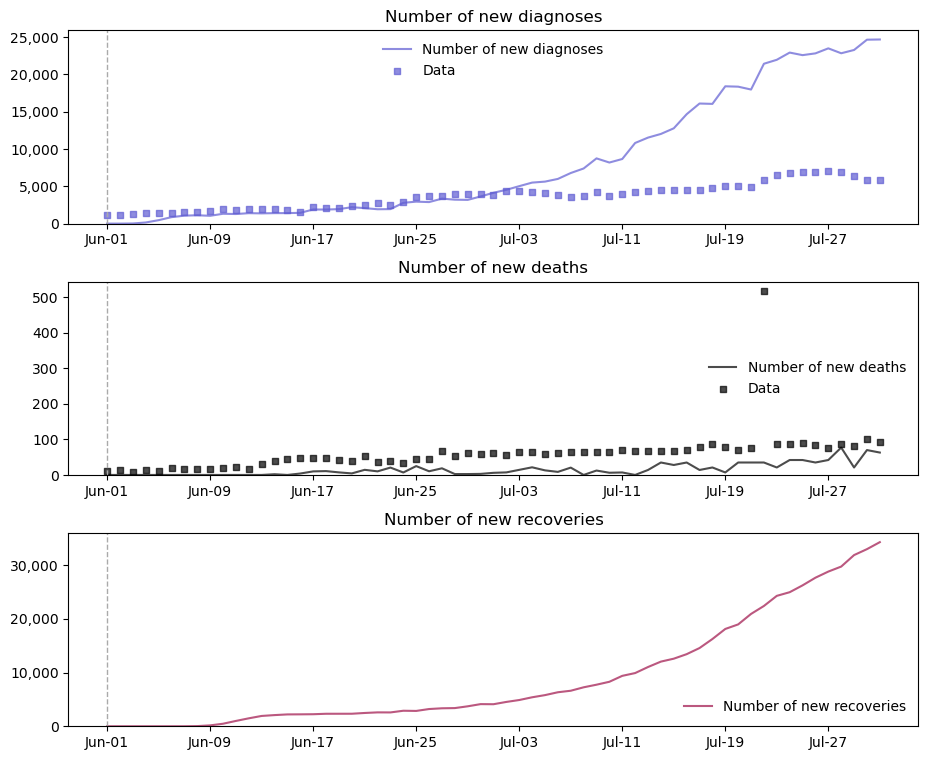

In [25]:
sim.plot(to_plot=['new_diagnoses', 'new_deaths', 'new_recoveries'])

[<Figure size 1200x800 with 4 Axes>]

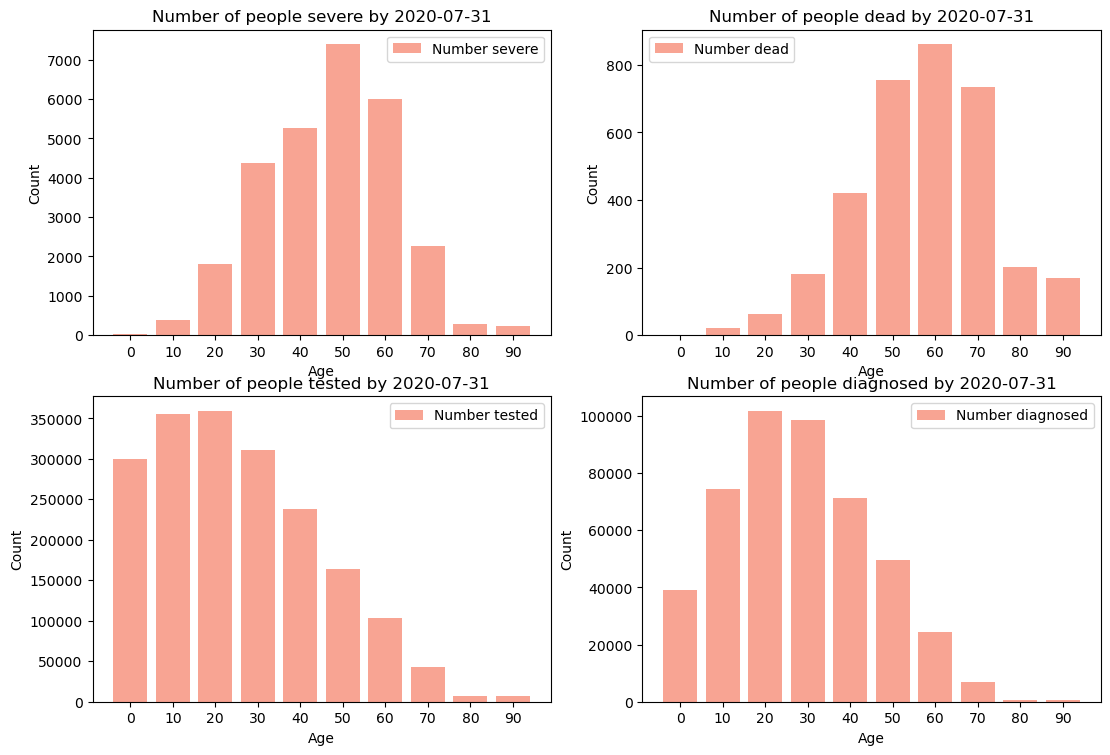

In [24]:
age_analyzer = cv.age_histogram(sim=sim, states=['severe', 'dead', 'tested', 'diagnosed'])
age_analyzer.plot()